In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

In [2]:
os.listdir(r'C:\Users\Administrator\annotations\trimaps')[-5:]

['yorkshire_terrier_95.png',
 'yorkshire_terrier_96.png',
 'yorkshire_terrier_97.png',
 'yorkshire_terrier_98.png',
 'yorkshire_terrier_99.png']

In [3]:
img =tf.io.read_file(r'C:\Users\Administrator\annotations\trimaps\yorkshire_terrier_99.png')

In [4]:
img=tf.image.decode_png(img)

In [5]:
img.shape

TensorShape([358, 500, 1])

In [6]:
tf.squeeze(img)

<tf.Tensor: shape=(358, 500), dtype=uint8, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)>

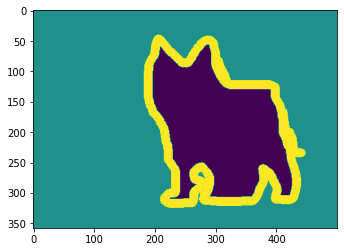

In [7]:
plt.imshow(img)

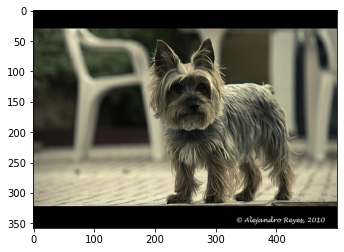

In [8]:
img =tf.io.read_file(r'C:\Users\Administrator\images\yorkshire_terrier_99.jpg')
img=tf.image.decode_jpeg(img)
plt.imshow(img)

################讀取數據##################

In [9]:
images =glob.glob(r'C:\Users\Administrator\images\*.jpg')
anno =glob.glob(r'C:\Users\Administrator\annotations\trimaps\*.png')

################讀取數據##################

################亂序##################

In [10]:
np.random.seed(2021)
index=np.random.permutation(len(images)) ######亂序

In [11]:
images=np.array(images)[index]

In [12]:
anno=np.array(anno)[index]

################亂序##################

In [13]:
images

array(['C:\\Users\\Administrator\\images\\staffordshire_bull_terrier_111.jpg',
       'C:\\Users\\Administrator\\images\\keeshond_163.jpg',
       'C:\\Users\\Administrator\\images\\beagle_197.jpg', ...,
       'C:\\Users\\Administrator\\images\\shiba_inu_100.jpg',
       'C:\\Users\\Administrator\\images\\japanese_chin_110.jpg',
       'C:\\Users\\Administrator\\images\\Bengal_45.jpg'], dtype='<U64')

In [14]:
anno

array(['C:\\Users\\Administrator\\annotations\\trimaps\\staffordshire_bull_terrier_111.png',
       'C:\\Users\\Administrator\\annotations\\trimaps\\keeshond_163.png',
       'C:\\Users\\Administrator\\annotations\\trimaps\\beagle_197.png',
       ...,
       'C:\\Users\\Administrator\\annotations\\trimaps\\shiba_inu_100.png',
       'C:\\Users\\Administrator\\annotations\\trimaps\\japanese_chin_110.png',
       'C:\\Users\\Administrator\\annotations\\trimaps\\Bengal_45.png'],
      dtype='<U77')

################資料處理##################

In [15]:
dataset=tf.data.Dataset.from_tensor_slices((images,anno))  #####讀取兩個檔案,轉成tf

In [16]:
test_count=int(len(images)*0.2)
train_count =len(images)-test_count  
data_train=dataset.skip(test_count)
data_test=dataset.take(test_count)       #####分割test/train

In [17]:
train_count

5912

In [18]:
data_train

<SkipDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [19]:
def read_jpg(path):
    img =tf.io.read_file(path)
    img=tf.image.decode_jpeg(img,channels=3)   ###彩色channels=3
    return img                                   ### 轉換jpg
def read_png(path):
    img =tf.io.read_file(path)
    img=tf.image.decode_png(img,channels=1)
    return img                                   ### 轉換PNG
def normal_img(input_images,input_anno):     
    input_images=tf.cast(input_images,tf.float32)
    input_images=input_images/127.5-1            
    input_anno=input_anno-1
    return input_images,input_anno              ###歸一
def load_images(input_images_path,input_anno_path): 
    input_image=read_jpg(input_images_path)   ### 讀取_轉換jpg
    input_anno =read_png(input_anno_path)     ### 讀取_轉換png
    input_image=tf.image.resize(input_image,(224,224))  ####重製大小
    input_anno=tf.image.resize(input_anno,(224,224))    ####重製大小
    return normal_img(input_image,input_anno)  ### 讀取_歸一

In [20]:
data_train=data_train.map(load_images,num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_test=data_test.map(load_images,num_parallel_calls=tf.data.experimental.AUTOTUNE)

##########讀取/轉換完成############

In [21]:
data_train

<ParallelMapDataset shapes: ((224, 224, 3), (224, 224, 1)), types: (tf.float32, tf.float32)>

In [22]:
data_train = data_train.repeat().shuffle(100).batch(8)
data_test = data_test.repeat().shuffle(100).batch(8)                 ######處理完之後 做repeat,shuffle,batch

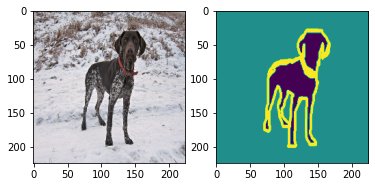

In [23]:
for img,anno in data_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[3]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(anno[3]))

#############資料處理轉換完畢##########################

#########使用VGG16訓練模型#############

In [24]:
conv_base=tf.keras.applications.VGG16(weights='imagenet',input_shape=(224,224,3),include_top=False)

In [25]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [26]:
conv_base.get_layer('block5_conv3').output

<KerasTensor: shape=(None, 14, 14, 512) dtype=float32 (created by layer 'block5_conv3')>

In [27]:
conv_base.outputs

[<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>]

In [28]:
conv_base.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

#############獲取特定層的輸出#################ˇ

In [29]:
sub_model=tf.keras.models.Model(inputs=conv_base.input,
                               outputs=conv_base.get_layer('block5_conv3').output)

In [30]:
sub_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

##########一次獲取多層輸出#####################

In [31]:
layer_names=['block5_conv3','block4_conv3','block3_conv3','block5_pool']

In [32]:
layers_output=[conv_base.get_layer(layer_name).output for layer_name in layer_names ]

In [33]:
layers_output

[<KerasTensor: shape=(None, 14, 14, 512) dtype=float32 (created by layer 'block5_conv3')>,
 <KerasTensor: shape=(None, 28, 28, 512) dtype=float32 (created by layer 'block4_conv3')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>]

In [34]:
multi_out_Model=tf.keras.models.Model(inputs=conv_base.input,
                                     outputs=layers_output)

In [35]:
multi_out_Model.trainable=False  ##不允許網路訓練

In [36]:
inputs=tf.keras.layers.Input(shape=(224,224,3))
out_block5_conv3,out_block4_conv3,out_block3_conv3,out=multi_out_Model(inputs)

In [37]:
out_block5_conv3.shape

TensorShape([None, 14, 14, 512])

In [38]:
out_block4_conv3.shape

TensorShape([None, 28, 28, 512])

In [39]:
out_block3_conv3.shape

TensorShape([None, 56, 56, 256])

In [40]:
out.shape

TensorShape([None, 7, 7, 512])

In [41]:
x1=tf.keras.layers.Conv2DTranspose(512,3,
                                  strides=2,padding='same',activation='relu')(out)
x1=tf.keras.layers.Conv2D(512,3,padding='same',activation='relu')(x1)

In [42]:
x1

<KerasTensor: shape=(None, 14, 14, 512) dtype=float32 (created by layer 'conv2d')>

In [43]:
x2=tf.add(x1,out_block5_conv3)
x2=tf.keras.layers.Conv2DTranspose(512,3,
                                  strides=2,padding='same',activation='relu')(x2)
x2=tf.keras.layers.Conv2D(512,3,padding='same',activation='relu')(x2)

In [44]:
x2

<KerasTensor: shape=(None, 28, 28, 512) dtype=float32 (created by layer 'conv2d_1')>

In [45]:
x3=tf.add(x2,out_block4_conv3)
x3=tf.keras.layers.Conv2DTranspose(512,3,
                                  strides=2,padding='same',activation='relu')(x3)
x3=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(x3)

In [46]:
x3

<KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'conv2d_2')>

In [47]:
x4=tf.add(x3,out_block3_conv3)
x4=tf.keras.layers.Conv2DTranspose(128,3,
                                  strides=2,padding='same',activation='relu')(x4)
x4=tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(x4)

In [48]:
x4

<KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'conv2d_3')>

In [49]:
prediction=tf.keras.layers.Conv2DTranspose(3,3,strides=2,padding='same',activation='softmax')(x4)

In [50]:
prediction.shape

TensorShape([None, 224, 224, 3])

In [51]:
model=tf.keras.models.Model(
inputs=inputs,
outputs=prediction

)

In [52]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'],)

In [58]:
history=model.fit(data_train,epochs=5,steps_per_epoch=train_count//8,validation_data=data_test,validation_steps=test_count/8)

Epoch 1/5
739/739 [==============================] - 104s 140ms/step - loss: 0.1839 - acc: 0.9220 - val_loss: 0.2540 - val_acc: 0.9049
Epoch 2/5
739/739 [==============================] - 105s 143ms/step - loss: 0.1696 - acc: 0.9270 - val_loss: 0.2677 - val_acc: 0.9054
Epoch 3/5
739/739 [==============================] - 106s 143ms/step - loss: 0.1601 - acc: 0.9303 - val_loss: 0.2782 - val_acc: 0.9033
Epoch 4/5
739/739 [==============================] - 145s 196ms/step - loss: 0.1468 - acc: 0.9351 - val_loss: 0.2905 - val_acc: 0.9049
Epoch 5/5
739/739 [==============================] - 184s 250ms/step - loss: 0.1382 - acc: 0.9383 - val_loss: 0.3067 - val_acc: 0.9042


In [54]:
 tf.__version__
    

'2.6.0'

In [63]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epoch=range(5)

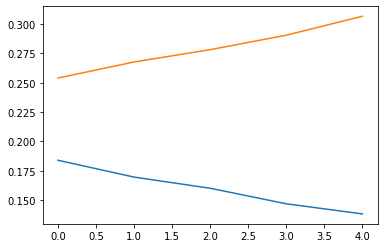

In [65]:
plt.plot(epoch,loss)
plt.plot(epoch,val_loss)

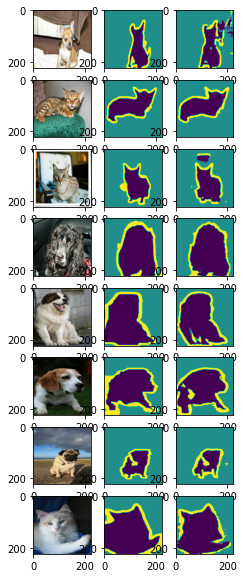

In [79]:
num=8
for image, mask in data_test.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 8, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 8, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 8, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))

In [80]:
#model.save('fcn.h5')